# What makes a good In Flight Check in?


Run this code in your anaconda command prompt before running this code: `conda install -c conda-forge imbalanced-learn `

*NEW!* Use the `target_number` below to set your threshhold for being a positive observation. Remember that it is based on the % increase from the three prior days to the 3 days to come!

In [51]:
target_number = .35

In [52]:
#import our basic data manipulation modules
import pandas as pd
import numpy as np
import scipy

#import our basic visualization modules
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#turn off warnings for sns depreciated versions- this is the best
import warnings
warnings.filterwarnings('ignore')

#import modules that describe distributions
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew

In [53]:
def target_value(df):
  if df['target%'] >= (target_number):
    return 1
  else:
    return 0

In [54]:
df = pd.read_csv("Dunder Mifflin Fundraising.csv")
df.head()

,ID,Hour_of_Day,Days_since_last_Checkin,Check_Ins,Contacts Created,Images Uploaded,Notes Written,Checkin_w_images,Checkin_w_Contact,Checkin_w_Note,...,Running average,last week change from running,Percentile of Running,Percentile of Running by Market,Percentile of Past 1-3,Percentile of Past 1-3 by Market,Percentile of Past 3-6,Percentile of Past 3-6 by Market,Percentile of Past Week Change,Percentile of Past Week Change by market
0,182887-5-12-2017,12,4,1,2,2,1,1,1,1,...,565.909091,2.451673,0.875,0.772,0.962,1.000,0.613,0.058,0.998,1.000
1,182887-5-15-2017,12,3,1,0,0,1,0,0,1,...,821.000000,1.139261,0.904,0.673,0.914,0.687,0.962,1.000,0.087,0.000
2,182887-5-18-2017,11,3,1,0,0,1,0,0,1,...,886.882353,0.346665,0.912,0.776,0.908,0.705,0.913,0.705,0.211,0.588
3,182887-5-22-2017,12,4,1,0,1,0,1,0,0,...,910.952381,-0.142656,0.894,0.734,0.723,0.294,0.932,0.882,0.014,0.000
4,182887-5-30-2017,12,8,1,0,0,0,0,0,0,...,898.896552,-0.166015,0.890,0.600,0.854,0.352,0.857,0.529,0.194,0.294


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2198 entries, 0 to 2197
Data columns (total 34 columns):
ID                                          2198 non-null object
Hour_of_Day                                 2198 non-null int64
Days_since_last_Checkin                     2198 non-null int64
Check_Ins                                   2198 non-null int64
Contacts Created                            2198 non-null int64
Images Uploaded                             2198 non-null int64
Notes Written                               2198 non-null int64
Checkin_w_images                            2198 non-null int64
Checkin_w_Contact                           2198 non-null int64
Checkin_w_Note                              2198 non-null int64
Checkin_w_I_C                               2198 non-null int64
Checkin_w_C_N                               2198 non-null int64
Checkin_w_I_N                               2198 non-null int64
Checkin_w_All                               2198 non-null in

In [57]:
#to get rid of new data uncomment the following
#df = df.drop(df[df['ID'].str[:2]="s"].index)

In [57]:
df['target%'] = ((df['Past 1-3 avg']-df['Future 0-3 avg'])/df['Future 0-3 avg'])
df['target'] = df.apply(target_value, axis=1)

#testing to see if we can use normalized variables only- would allow it to generalize over other corporate partners potentially
df = df.drop(['Campaign Day Funds','day of month','target%','Future 0-3 avg','Past 1-3 avg','Past 3-6 avg','Running average','FundraisingYear'],axis=1)
#df = df.drop(['Campaign Day Funds','day of month','target%','Future 0-3 avg'],axis=1)
#df[['Hour_of_Day','FundraisingYear','day of week']] = df[['Hour_of_Day','FundraisingYear','day of week']].astype('category')
df[['Hour_of_Day','day of week']] = df[['Hour_of_Day','day of week']].astype('category')

In [58]:
df = pd.get_dummies(data=df,
                    columns=['Hour_of_Day','day of week'])
                    #columns=['Hour','Property Type','PopulationRank','LocRegion','FundraisingYear','day of week'])

In [59]:
#Create a list that displays only numeric variables
numeric_var=df.select_dtypes(include=[np.number]).columns
#Here we set up our correlation matrix for numeric variables
correlation=df[numeric_var].corr()
#Pull the max (whether positive or negative) correlation of each variable to another variable
aux=(abs(correlation)-np.identity(correlation.shape[0])).max()

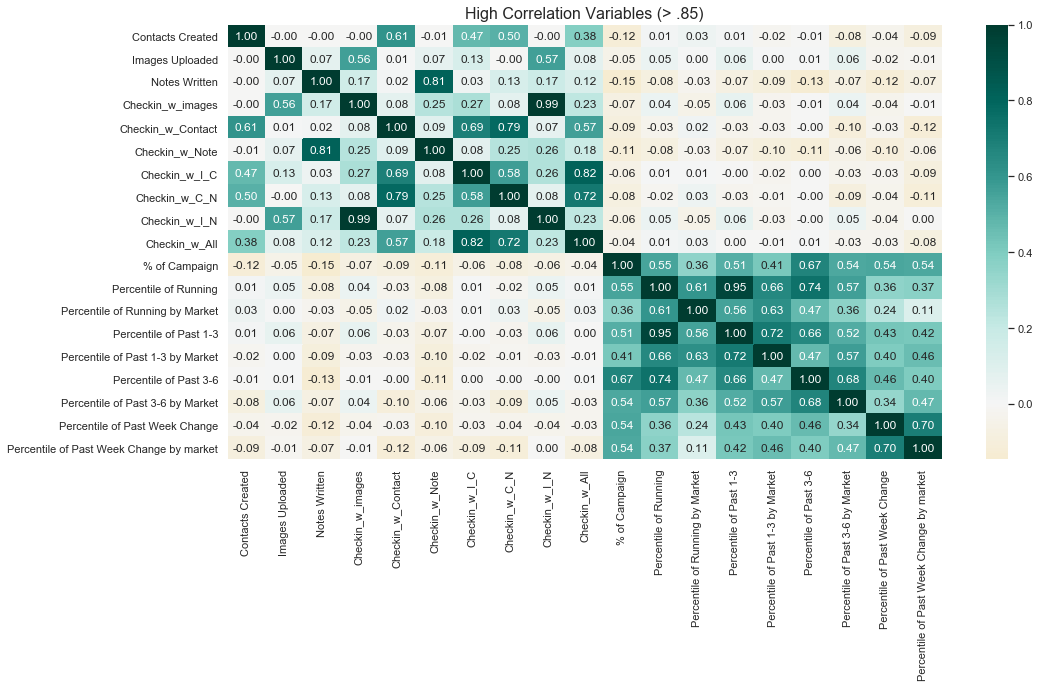

In [60]:
#Throw out any variables that don't have at least .7 correlation with something else or isn't Target
selected_feats=aux[(aux>0.50)| ((aux>0.215207) & (aux<0.215209))].index
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
#make the plot have numbers, a legend and pretty colors
sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax,cmap="BrBG",center=0)
plt.title('High Correlation Variables (> .85)',fontsize=16)
#show the plot
plt.show()


In [61]:
correlation = df.corr()
correlation = correlation['target'].sort_values(ascending=False)
correlation

target                                      1.000000
last week change from running               0.432965
Change in past week                         0.179183
Checkin_w_I_N                               0.097878
Checkin_w_images                            0.097553
day of week_7                               0.085693
Images Uploaded                             0.070536
Hour_of_Day_13                              0.065595
Percentile of Past 1-3                      0.060596
day of week_6                               0.054942
Hour_of_Day_1                               0.029435
Hour_of_Day_23                              0.029435
Hour_of_Day_14                              0.027143
day of week_1                               0.023265
day of week_2                               0.019731
Contacts Created                            0.018358
Hour_of_Day_11                              0.015306
Checkin_w_I_C                               0.014324
Percentile of Past 1-3 by Market            0.

In [62]:
#df = df.drop(['Checkin_w_I_N','LocRegion_BC','LocRegion_CWI','LocRegion_Regional','FundraisingYear_2017','Week'],axis=1)
df = df.drop(['Checkin_w_I_N'],axis=1)

In [63]:
df.describe()

,Days_since_last_Checkin,Check_Ins,Contacts Created,Images Uploaded,Notes Written,Checkin_w_images,Checkin_w_Contact,Checkin_w_Note,Checkin_w_I_C,Checkin_w_C_N,...,Hour_of_Day_21,Hour_of_Day_22,Hour_of_Day_23,day of week_1,day of week_2,day of week_3,day of week_4,day of week_5,day of week_6,day of week_7
count,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,...,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000,2198.000000
mean,17.782985,0.954959,0.143767,1.581893,0.570974,0.405369,0.092357,0.527753,0.044586,0.058235,...,0.004095,0.003640,0.000455,0.027753,0.142402,0.204277,0.208826,0.189718,0.152411,0.074613
std,12.130970,0.309566,0.478281,2.858104,0.549932,0.521638,0.298876,0.530288,0.217185,0.243762,...,0.063873,0.060234,0.021330,0.164300,0.349542,0.403264,0.406562,0.392167,0.359501,0.262826
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,30.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,3.000000,7.000000,39.000000,3.000000,3.000000,2.000000,3.000000,2.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Modeling

In [64]:
#Import the models we will be using
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

#Bring in our crossvalidations
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, KFold, learning_curve, StratifiedKFold, StratifiedShuffleSplit

#Import the modules we will use to score our models
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, accuracy_score, mean_squared_error, log_loss, roc_auc_score, average_precision_score, precision_score
import itertools
from imblearn.over_sampling import SMOTENC,SMOTE,ADASYN
from collections import Counter

In [65]:
#Retain our id fields
Id = df['ID']
#Create the two new data frames
train_y = pd.DataFrame()
train_x = pd.DataFrame()
#save our Target as our y variable
train_y['target'] = df['target']
train_x = df.drop(['target','ID'],axis=1)

In [66]:
#perform the train & test split
X1_train, X_test, y1_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=10, stratify=train_y)

### *Oversampling through synthetic observation creation*

In [67]:
print(X1_train.shape)
print(y1_train.shape)

Original dataset shape Counter({'target': 1})
(1758, 51)
(1758, 1)


In [68]:
sm = ADASYN(random_state=42,n_jobs=-1)
res_x, res_y = sm.fit_resample(X1_train, y1_train)
y_train = pd.DataFrame(res_y)
X_train = pd.DataFrame(res_x)

In [69]:
print('New dataset shape %s' % Counter(res_y))
labels = np.unique(y_train)
print(labels)

Original dataset shape Counter({1: 1179, 0: 1153})
[0 1]


In [70]:
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [71]:
F1_scorer = make_scorer(f1_score, greater_is_better=True, average='micro')
tpr = make_scorer(average_precision_score)
pre = make_scorer(precision_score)
scoring = pre

In [77]:
#Create a variable that will show us the best parameters, with what accuracy it predicts and what the F1 score is for its predictions
def show_me_the_money(model,test_y,test_x,train_y=y_train,train_x=X_train):
    #print("Best Params: {}".format(model.best_params_))
    print('Scoring Metrics')
    train_predictions = model.predict(train_x)
    test_predictions = model.predict(test_x)
    print('*******************************************************')
    print(scoring)
    print("Train Accuracy: {}".format(accuracy_score(y_train, train_predictions)))
    print("Test Accuracy: {}".format(accuracy_score(y_test, test_predictions)))

    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    
    train_auc = roc_auc_score(y_train, train_predictions)
    test_auc = roc_auc_score(y_test, test_predictions)
    
    train_tpr = roc_auc_score(y_train, train_predictions)
    test_tpr = roc_auc_score(y_test, test_predictions)
    
    print('*******************************************************')
    print("Train MSE: {}".format(train_mse))
    print("Test MSE: {}".format(test_mse))
    print('*******************************************************')
    print("Train ROC AUC: {}".format(train_auc))
    print("Test ROC AUC: {}".format(test_auc))
    print('*******************************************************')
    print("Train F1 Score: {}".format(f1_score(y_train, train_predictions,average='macro')))
    print("Test F1 Score: {}".format(f1_score(test_y, model.predict(test_x),average='macro')))
    print('*******************************************************')
    print("Train ROC AUC: {}".format(train_tpr))
    print("Test ROC AUC: {}".format(test_tpr))
    print('*******************************************************')
    

In [73]:
#generalized confusion matrix plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize = (8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted label', size = 16)

    
#specific matrix for our needs    
def show_con_matrix(model,test_y,test_x,title):
    pred_matrix = confusion_matrix(test_y, model.predict(test_x))
    plot_confusion_matrix(pred_matrix, classes = ['Less effective', 'More effective'],
                      title = title)
    plt.show

In [74]:
## source: http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring,shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Support Vector Classification

In [75]:
#set up model, allow it to use all cores
svc = svm.SVC(class_weight='balanced')

#set hyperparameters
param_grid = {"C": [.25,.05,1,1.5,2],
              "gamma":['auto','scale'],
             "decision_function_shape":['ovo','ovr'],
             "shrinking":[True,False],
             "tol":[.00001,.0001,.001,.01,.1]}

#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
svc_gridsearch = GridSearchCV(svc,param_grid=param_grid,scoring=scoring,cv=5)

#fit model
svc_gridsearch.fit(X_train,y_train)

#save model
optimised_svc = svc_gridsearch.best_estimator_
optimised_svc

SVC(C=1.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=1e-05, verbose=False)

In [78]:
#see how it did
show_me_the_money(optimised_svc,y_test,X_test)

Scoring Metrics
*******************************************************
make_scorer(precision_score)
Train Accuracy: 0.9193825042881647
Test Accuracy: 0.8431818181818181
*******************************************************
Train MSE: 0.08061749571183534
Test MSE: 0.15681818181818183
*******************************************************
Train ROC AUC: 0.9196880652823662
Test ROC AUC: 0.8056469298245614
*******************************************************
Train F1 Score: 0.9193587785360915
Test F1 Score: 0.8182373331896474
*******************************************************
Train ROC AUC: 0.9196880652823662
Test ROC AUC: 0.8056469298245614
*******************************************************


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

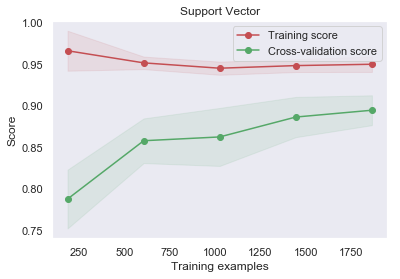

In [79]:
plot_learning_curve(optimised_svc,'Support Vector',X=X_train,y=y_train,cv=5,n_jobs=-1)

Confusion matrix, without normalization


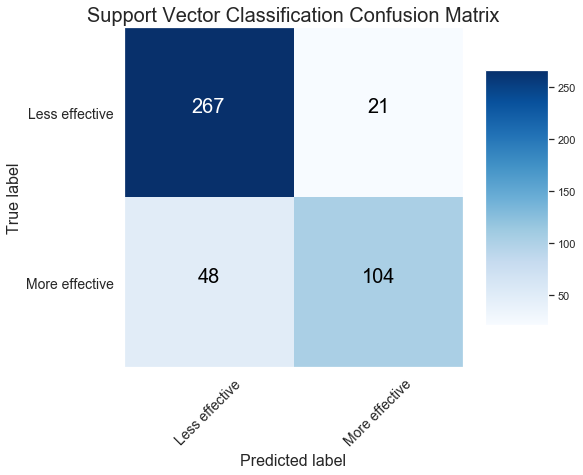

In [80]:
#Show confusion matrix
show_con_matrix(optimised_svc,y_test, X_test,'Support Vector Classification Confusion Matrix')

### Stochiastic Gradient Descent

In [81]:
#set up model, allow it to use all cores
sgd = SGDClassifier(n_jobs=-1,class_weight='balanced')

#set hyperparameters
param_dist = {"loss": ['hinge', 'log', 'modified_huber','squared_hinge', 'perceptron'],
             "l1_ratio" :[0, .001, .04, .5, .69, .8, .9,1],
             "penalty":['none', 'l2', 'l1', 'elasticnet'],
             "alpha":[.00001,.0001,.001],
             "learning_rate":['constant','optimal','invscaling','adaptive'],
             "eta0":[.000000001,.000000005,.00000001,.00000005,.0000001,.0000005,.000001,.000005]}

#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
sgd_gridsearch = RandomizedSearchCV(sgd,param_distributions=param_dist,scoring=scoring,cv=5,n_iter=1000)

#fit model
sgd_gridsearch.fit(X_train,y_train)

#save model
optimised_sgd = sgd_gridsearch.best_estimator_
optimised_sgd

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=5e-06, fit_intercept=True,
       l1_ratio=0.5, learning_rate='invscaling', loss='perceptron',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=-1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False)

In [82]:
#see how it did
show_me_the_money(optimised_sgd,y_test,X_test)

Scoring Metrics
*******************************************************
make_scorer(precision_score)
Train Accuracy: 0.7474271012006861
Test Accuracy: 0.7636363636363637
*******************************************************
Train MSE: 0.2525728987993139
Test MSE: 0.23636363636363636
*******************************************************
Train ROC AUC: 0.747773444942463
Test ROC AUC: 0.7495431286549707
*******************************************************
Train F1 Score: 0.7472965725708156
Test F1 Score: 0.7439512970299245
*******************************************************
Train ROC AUC: 0.747773444942463
Test ROC AUC: 0.7495431286549707
*******************************************************


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

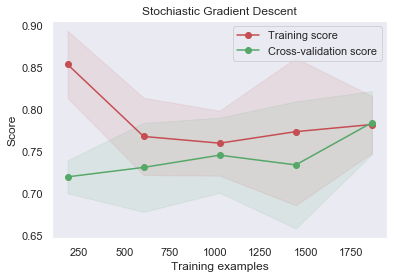

In [83]:
#High is Better
plot_learning_curve(optimised_sgd,'Stochiastic Gradient Descent',X_train,y_train,cv=5,n_jobs=-1)

Confusion matrix, without normalization


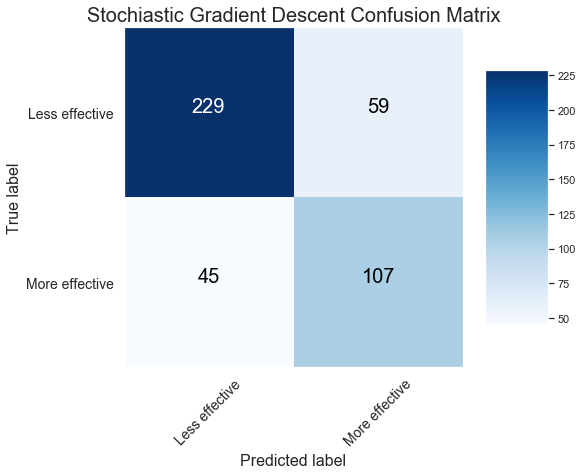

In [84]:
#Show confusion matrix
show_con_matrix(optimised_sgd,y_test, X_test,'Stochiastic Gradient Descent Confusion Matrix')

### K-Nearest Neighbors

In [85]:
#set up model, allow it to use all cores
knk = KNeighborsClassifier(n_jobs = -1)

#set hyperparameters
param_grid = {"n_neighbors": [3,4, 5,6, 7,],
             "weights": ['uniform','distance'],
              "p": [1,2,3]}

#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
knk_gridsearch = GridSearchCV(knk,param_grid=param_grid,scoring=scoring,cv=5)

#fit model
knk_gridsearch.fit(X_train,y_train)

#save model
optimised_knk = knk_gridsearch.best_estimator_
optimised_knk

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=6, p=1,
           weights='uniform')

In [86]:
#see how it did
show_me_the_money(optimised_knk,y_test,X_test)

Scoring Metrics
*******************************************************
make_scorer(precision_score)
Train Accuracy: 0.8807890222984562
Test Accuracy: 0.8159090909090909
*******************************************************
Train MSE: 0.11921097770154374
Test MSE: 0.18409090909090908
*******************************************************
Train ROC AUC: 0.881644447092697
Test ROC AUC: 0.7692799707602339
*******************************************************
Train F1 Score: 0.8802531563268394
Test F1 Score: 0.7831576001314197
*******************************************************
Train ROC AUC: 0.881644447092697
Test ROC AUC: 0.7692799707602339
*******************************************************


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

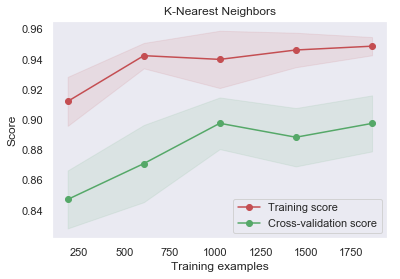

In [87]:
#High is Better
plot_learning_curve(optimised_knk,'K-Nearest Neighbors',X_train,y_train,cv=5,n_jobs=-1)

*For high variance:*

- Get more training data
- Try a smaller set of features
- Try a less complex model
- Add regularization - Prevents it from fitting

Confusion matrix, without normalization


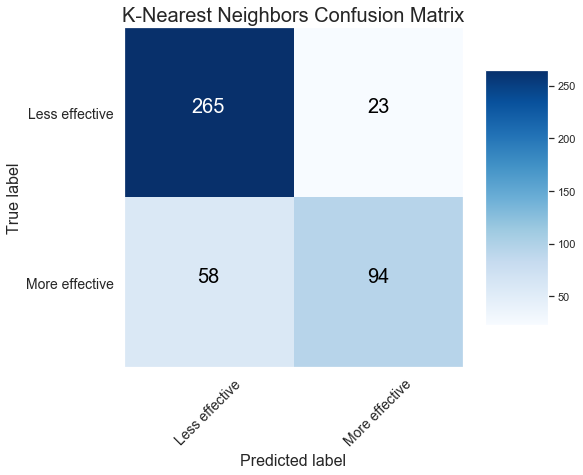

In [88]:
#Show confusion matrix
show_con_matrix(optimised_knk,y_test, X_test,'K-Nearest Neighbors Confusion Matrix')

### Random Forrest Classifiers

In [89]:
#set up model, allow it to use all cores
rfc = RandomForestClassifier(random_state=42, n_jobs = -1)

#set hyperparameters
param_grid = {"n_estimators": [ 105, 110, 115, 120],
             "min_samples_leaf":[1,2,3,4],
             "class_weight":["balanced", "balanced_subsample"]}


#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
rfc_gridsearch = GridSearchCV(rfc,param_grid=param_grid,scoring=scoring,cv=5,n_jobs=-1)

#fit model
rfc_gridsearch.fit(X_train,y_train)

#save model
optimised_rfc = rfc_gridsearch.best_estimator_

In [90]:
#see how it did
show_me_the_money(optimised_rfc,y_test,X_test)

Scoring Metrics
*******************************************************
make_scorer(precision_score)
Train Accuracy: 1.0
Test Accuracy: 0.8977272727272727
*******************************************************
Train MSE: 0.0
Test MSE: 0.10227272727272728
*******************************************************
Train ROC AUC: 1.0
Test ROC AUC: 0.8644005847953216
*******************************************************
Train F1 Score: 1.0
Test F1 Score: 0.8809917355371901
*******************************************************
Train ROC AUC: 1.0
Test ROC AUC: 0.8644005847953216
*******************************************************


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

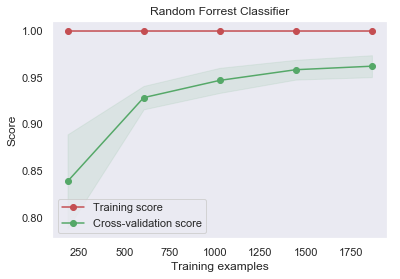

In [91]:
#High is Better
plot_learning_curve(optimised_rfc,'Random Forrest Classifier',X_train,y_train,cv=5,n_jobs=-1)

*For high variance:*

- Get more training data
- Try a smaller set of features
- Try a less complex model
- Add regularization - Prevents it from fitting

Confusion matrix, without normalization


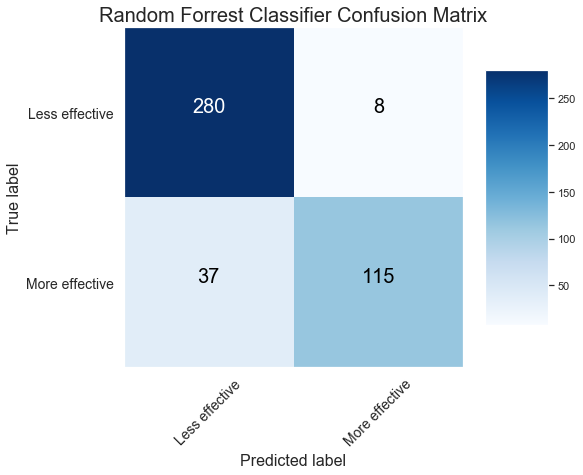

In [92]:
#Show confusion matrix
show_con_matrix(optimised_rfc,y_test, X_test,'Random Forrest Classifier Confusion Matrix')

Text(0.5, 1.0, 'Feature Importances')

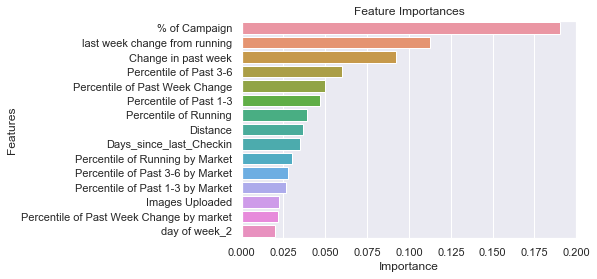

In [93]:
#Retrieve feature importances and insert them into a dataframe
imp_feat_rfc = sorted(list(zip(train_x.columns, optimised_rfc.feature_importances_)), key=lambda x: x[1], reverse=True)
#Create a plot of the top ten importances
importance_rfc = pd.DataFrame(imp_feat_rfc,columns=['Features','Importance'])
sns.barplot('Importance','Features',data=importance_rfc.head(15))
plt.title('Feature Importances')

### Deep Learning
https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification

In [94]:
#set up model, allow it to use all cores
dl = MLPClassifier(random_state=1,early_stopping=True)

#set hyperparameters
param_grid = {"solver": ['lbfgs', 'sgd', 'adam'],
             "alpha": [1e-5,1e-4,1e-3,1e-2,1,10]}


#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
dl_gridsearch = GridSearchCV(dl,param_grid=param_grid,scoring=scoring,cv=5)

#fit model
dl_gridsearch.fit(X_train,y_train)

#save model
optimised_dl = dl_gridsearch.best_estimator_

In [95]:
#see how it did
show_me_the_money(optimised_dl,y_test,X_test)

Scoring Metrics
*******************************************************
make_scorer(precision_score)
Train Accuracy: 0.9995711835334476
Test Accuracy: 0.8454545454545455
*******************************************************
Train MSE: 0.0004288164665523156
Test MSE: 0.15454545454545454
*******************************************************
Train ROC AUC: 0.9995663486556808
Test ROC AUC: 0.8260233918128654
*******************************************************
Train F1 Score: 0.9995711260424147
Test F1 Score: 0.8280459770114943
*******************************************************
Train ROC AUC: 0.9995663486556808
Test ROC AUC: 0.8260233918128654
*******************************************************


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

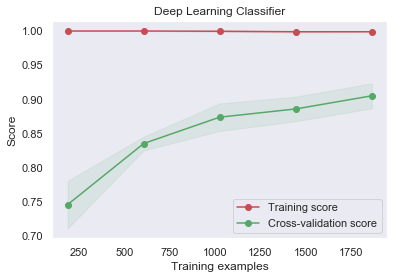

In [96]:
#High is Better
plot_learning_curve(optimised_dl,'Deep Learning Classifier',X_train,y_train,cv=5,n_jobs=-1)

*For high variance:*

- Get more training data
- Try a smaller set of features
- Try a less complex model
- Add regularization - Prevents it from fitting

Confusion matrix, without normalization


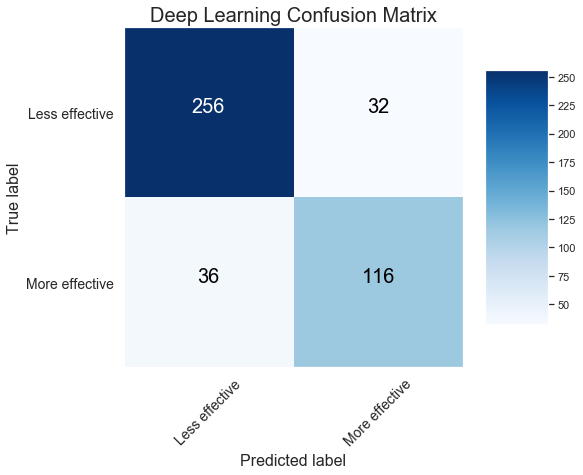

In [97]:
#Show confusion matrix
show_con_matrix(optimised_dl,y_test, X_test,'Deep Learning Confusion Matrix')

## Gradient Boosting
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [98]:
#set up model, allow it to use all cores
gbc = GradientBoostingClassifier()

#set hyperparameters
param_grid = {"learning_rate": [.0001,.001,.01,.05,.9],
             "n_estimators": [50,100,150],
             "max_depth":[2,3,4,5]}


#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
gbc_gridsearch = GridSearchCV(gbc,param_grid=param_grid,scoring=scoring,cv=5)

#fit model
gbc_gridsearch.fit(X_train,y_train)

#save model
optimised_gbc = gbc_gridsearch.best_estimator_
optimised_gbc

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [99]:
#see how it did
show_me_the_money(optimised_gbc,y_test,X_test)

Scoring Metrics
*******************************************************
make_scorer(precision_score)
Train Accuracy: 0.8674957118353345
Test Accuracy: 0.9022727272727272
*******************************************************
Train MSE: 0.13250428816466553
Test MSE: 0.09772727272727273
*******************************************************
Train ROC AUC: 0.8685933439116308
Test ROC AUC: 0.872532894736842
*******************************************************
Train F1 Score: 0.8664433890137386
Test F1 Score: 0.8871653576178293
*******************************************************
Train ROC AUC: 0.8685933439116308
Test ROC AUC: 0.872532894736842
*******************************************************


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

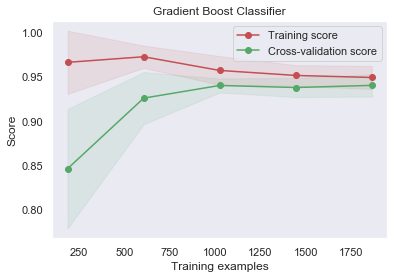

In [100]:
#High is Better
plot_learning_curve(optimised_gbc,'Gradient Boost Classifier',X_train,y_train,cv=5,n_jobs=-1)

Confusion matrix, without normalization


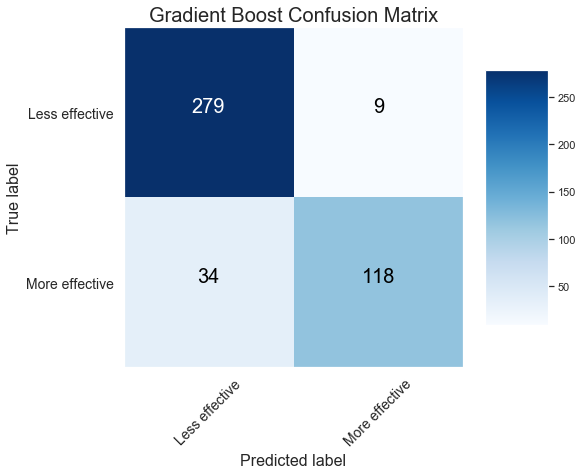

In [101]:
#Show confusion matrix
show_con_matrix(optimised_gbc,y_test, X_test,'Gradient Boost Confusion Matrix')

Text(0.5, 1.0, 'Feature Importances')

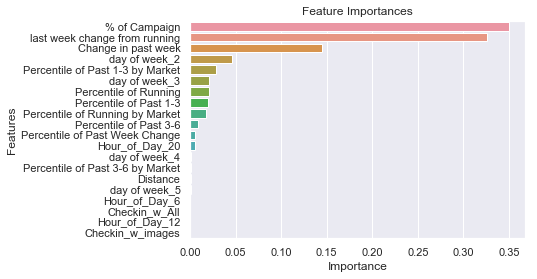

In [102]:
#Retrieve feature importances and insert them into a dataframe
imp_feat_gbc = sorted(list(zip(train_x.columns, optimised_gbc.feature_importances_)), key=lambda x: x[1], reverse=True)
#Create a plot of the top ten importances
importance_gbc = pd.DataFrame(imp_feat_gbc,columns=['Features','Importance'])
sns.barplot('Importance','Features',data=importance_gbc.head(20))
plt.title('Feature Importances')

## XGBoost
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [104]:
#X_test_xgb = X_test.as_matrix()
#X_train_xgb = X_train.as_matrix()

#set up model, allow it to use all cores
xgb = XGBClassifier(gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

#set hyperparameters
param_dist = { 'max_depth':range(3,10),
             'min_child_weight':range(6,12),
             "n_estimators":range(100,400,5),
             "learning_rate":[.0000001,.000001,.00001,.0001,.001,.01,.1]}


#set up the grid search, with 5 crossvalidations and scoring based on our F1_scorer that we created
xgb_gridsearch = RandomizedSearchCV(xgb,param_distributions=param_dist,scoring=scoring,cv=5,n_iter=20)#,n_jobs=-1)

#fit model
xgb_gridsearch.fit(X_train,y_train)

#save model
optimised_xgb = xgb_gridsearch.best_estimator_
optimised_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=6, missing=None, n_estimators=390,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

In [105]:
#see how it did
show_me_the_money(optimised_xgb,test_y=y_test,test_x=X_test)

Scoring Metrics
*******************************************************
make_scorer(precision_score)
Train Accuracy: 0.95926243567753
Test Accuracy: 0.9068181818181819
*******************************************************
Train MSE: 0.040737564322469985
Test MSE: 0.09318181818181819
*******************************************************
Train ROC AUC: 0.9594534153997354
Test ROC AUC: 0.8837719298245614
*******************************************************
Train F1 Score: 0.9592607501398952
Test F1 Score: 0.8940014454348351
*******************************************************
Train ROC AUC: 0.9594534153997354
Test ROC AUC: 0.8837719298245614
*******************************************************


<module 'matplotlib.pyplot' from 'C:\\Users\\zgeorge\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

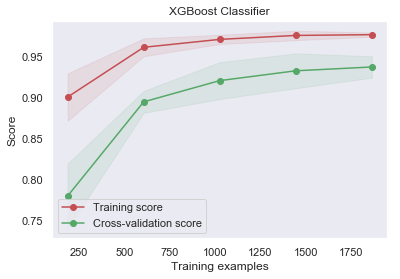

In [106]:
#High is Better
plot_learning_curve(optimised_xgb,'XGBoost Classifier',X_train,y_train,cv=5,n_jobs=-1)

Confusion matrix, without normalization


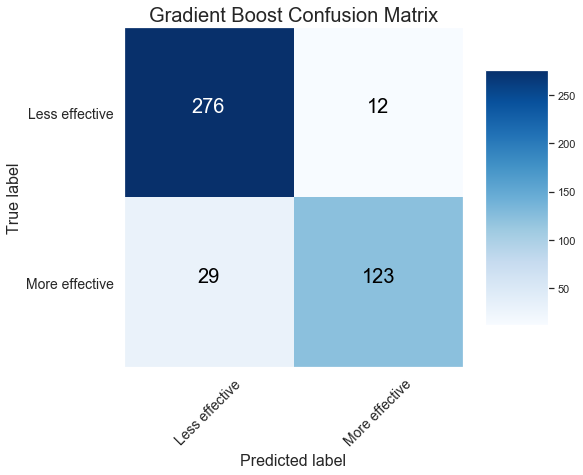

In [107]:
#Show confusion matrix
show_con_matrix(optimised_xgb,y_test, X_test,'Gradient Boost Confusion Matrix')

Text(0.5, 1.0, 'Feature Importances')

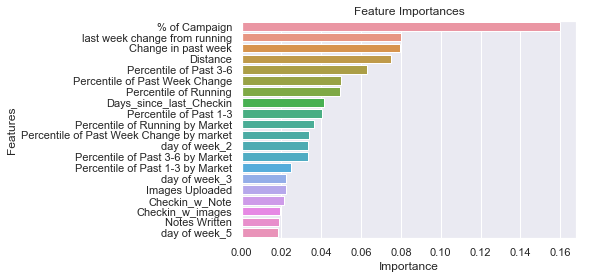

In [110]:
#Retrieve feature importances and insert them into a dataframe
imp_feat_xgb = sorted(list(zip(train_x.columns, optimised_xgb.feature_importances_)), key=lambda x: x[1], reverse=True)
#Create a plot of the top ten importances
importance_xgb = pd.DataFrame(imp_feat_xgb,columns=['Features','Importance'])
sns.barplot('Importance','Features',data=importance_xgb.head(20))
plt.title('Feature Importances')